In [51]:
# необходимый импорт
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2")
%matplotlib inline

from sklearn.model_selection import train_test_split # разделение выборок
from sklearn.metrics import mutual_info_score, accuracy_score, precision_score # взаимная ифнормация признаков
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

RANDOM_STATE=42

## Первичный анализ данных

In [52]:
# считываем данные
df = pd.read_csv('data\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [54]:
total_charges = pd.to_numeric(df['TotalCharges'], errors='coerce')
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [55]:
# исправляем тип столбца TotalCharges на числовой
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [56]:
# переводим названяи столбцов в нижний регистр и меняем пробелы на _
df.columns = df.columns.str.lower().str.replace(' ', '_')

# собираем список строковых столбцов
string_col = list(df.dtypes[df.dtypes == 'object'].index)

# в столбцах понижаем регистр, меняем пробелы на _
for col in string_col:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.head(3).T

,0,1,2
customerid,7590-vhveg,5575-gnvde,3668-qpybk
gender,female,male,male
seniorcitizen,0,0,0
partner,yes,no,no
dependents,no,no,no
tenure,1,34,2
phoneservice,no,yes,yes
multiplelines,no_phone_service,no,no
internetservice,dsl,dsl,dsl
onlinesecurity,no,yes,yes


In [57]:
# преобразуем целевую переменную в int
df['churn'] = df['churn'].apply(lambda x:1 if x =='yes' else 0)
df['churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [58]:
# разбиваем данные на тренировочные и тестовые
df_train_full, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_STATE)

# Разбиваем тренировочные данные на тренировочные и валидационные
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=RANDOM_STATE)

In [59]:
# запишем целевую переменную
y_train = df_train['churn']
y_val = df_val['churn']
y_test = df_test['churn']

# удалим целевую переменную из обучающих наборов
del df_train['churn']
del df_val['churn']
del df_test['churn']

## EDA

In [60]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Дополнительаня обработка пропусков не требуется

### Анализ целевой переменной

In [61]:
df_train_full['churn'].value_counts()

0    4663
1    1675
Name: churn, dtype: int64

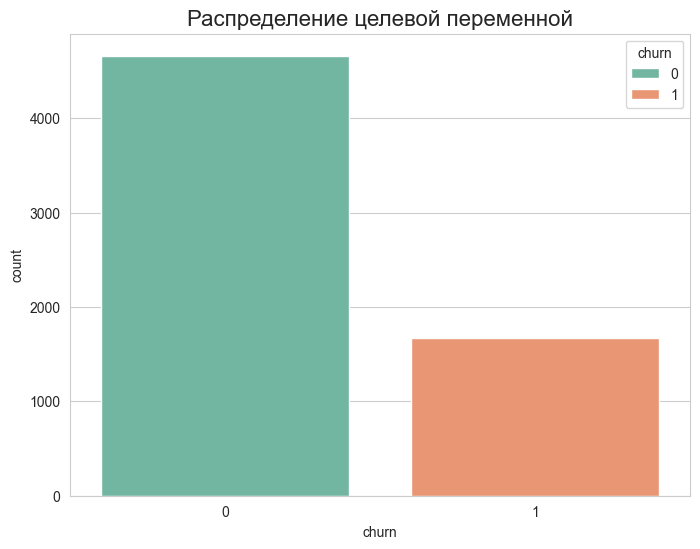

In [107]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(df_train_full, x='churn', hue='churn')
ax.set_title('Распределение целевой переменной', fontsize=16)
plt.show()

In [63]:
# вычислим долю ушедших клиентов
print(f'коэффициент оттока - {round(1675/6338, 2)}')

коэффициент оттока - 0.26


### Анализ признаков

In [64]:
df_train_full.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [65]:
# разделим признаки на числовые и категариальные

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling','paymentmethod']

numeric = ['tenure', 'monthlycharges', 'totalcharges']

In [66]:
# проверим количество уникальных значений переменных
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

Количество уникальных катигорий не превышает 4, по этому можно будет воспользоваться DictVectorizer для кодирования

#### Оценка важности признаков

In [67]:
# Коэффициент оттока

#female_mean = df_train_full[df_train_full['gender'] == 'female']['churn'].mean()
#male_mean = df_train_full[df_train_full['gender'] == 'male']['churn'].mean()

#print(f'female: {round(female_mean,2)}')
#print(f'male: {round(male_mean,2)}')

In [68]:
# Коэффициент оттока
global_mean =  df_train_full['churn'].mean()

for col in categorical:
    df_group = df_train_full.groupby(col)['churn'].agg(['mean'])
    display(df_group)

,mean
gender,
female,0.269490
male,0.259236


,mean
seniorcitizen,
0,0.234707
1,0.417561


,mean
partner,
no,0.325994
yes,0.198501


,mean
dependents,
no,0.310811
yes,0.155427


,mean
phoneservice,
no,0.251208
yes,0.265699


,mean
multiplelines,
no,0.249176
no_phone_service,0.251208
yes,0.284383


,mean
internetservice,
dsl,0.190215
fiber_optic,0.416366
no,0.075527


,mean
onlinesecurity,
no,0.414897
no_internet_service,0.075527
yes,0.145072


,mean
onlinebackup,
no,0.397900
no_internet_service,0.075527
yes,0.214643


,mean
deviceprotection,
no,0.389666
no_internet_service,0.075527
yes,0.223091


,mean
techsupport,
no,0.411690
no_internet_service,0.075527
yes,0.154098


,mean
streamingtv,
no,0.332541
no_internet_service,0.075527
yes,0.300246


,mean
streamingmovies,
no,0.333333
no_internet_service,0.075527
yes,0.299879


,mean
contract,
month-to-month,0.425569
one_year,0.113095
two_year,0.029586


,mean
paperlessbilling,
no,0.162755
yes,0.334849


,mean
paymentmethod,
bank_transfer_(automatic),0.169075
credit_card_(automatic),0.155539
electronic_check,0.447628
mailed_check,0.188782


In [69]:
# Коэффициент риска

global_mean =  df_train_full['churn'].mean()

for col in categorical:
    df_group = df_train_full.groupby(col)['churn'].agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.269490,0.005211,1.019718
male,0.259236,-0.005043,0.980919


,mean,diff,risk
seniorcitizen,,,
0,0.234707,-0.029572,0.888104
1,0.417561,0.153282,1.580001


,mean,diff,risk
partner,,,
no,0.325994,0.061715,1.233522
yes,0.198501,-0.065778,0.751103


,mean,diff,risk
dependents,,,
no,0.310811,0.046532,1.176071
yes,0.155427,-0.108852,0.588116


,mean,diff,risk
phoneservice,,,
no,0.251208,-0.013071,0.950540
yes,0.265699,0.001420,1.005373


,mean,diff,risk
multiplelines,,,
no,0.249176,-0.015103,0.942852
no_phone_service,0.251208,-0.013071,0.950540
yes,0.284383,0.020104,1.076072


,mean,diff,risk
internetservice,,,
dsl,0.190215,-0.074064,0.719750
fiber_optic,0.416366,0.152087,1.575480
no,0.075527,-0.188752,0.285783


,mean,diff,risk
onlinesecurity,,,
no,0.414897,0.150618,1.569921
no_internet_service,0.075527,-0.188752,0.285783
yes,0.145072,-0.119207,0.548935


,mean,diff,risk
onlinebackup,,,
no,0.397900,0.133621,1.505606
no_internet_service,0.075527,-0.188752,0.285783
yes,0.214643,-0.049636,0.812184


,mean,diff,risk
deviceprotection,,,
no,0.389666,0.125387,1.474451
no_internet_service,0.075527,-0.188752,0.285783
yes,0.223091,-0.041188,0.844150


,mean,diff,risk
techsupport,,,
no,0.411690,0.147411,1.557784
no_internet_service,0.075527,-0.188752,0.285783
yes,0.154098,-0.110181,0.583090


,mean,diff,risk
streamingtv,,,
no,0.332541,0.068262,1.258294
no_internet_service,0.075527,-0.188752,0.285783
yes,0.300246,0.035967,1.136095


,mean,diff,risk
streamingmovies,,,
no,0.333333,0.069054,1.261294
no_internet_service,0.075527,-0.188752,0.285783
yes,0.299879,0.035600,1.134705


,mean,diff,risk
contract,,,
month-to-month,0.425569,0.161290,1.610301
one_year,0.113095,-0.151184,0.427939
two_year,0.029586,-0.234693,0.111949


,mean,diff,risk
paperlessbilling,,,
no,0.162755,-0.101524,0.615845
yes,0.334849,0.070570,1.267028


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.169075,-0.095204,0.639760
credit_card_(automatic),0.155539,-0.108740,0.588542
electronic_check,0.447628,0.183349,1.693771
mailed_check,0.188782,-0.075496,0.714330


In [70]:
# взаимная информация
# функция для вычисления взаимной информации
def calculate_mi(series):
    return mutual_info_score(series, df_train_full['churn'])

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending = False).to_frame(name='MI')

display(df_mi[df_mi['MI'] > 0.03])

,MI
contract,0.096928
onlinesecurity,0.063540
techsupport,0.060567
internetservice,0.054216
onlinebackup,0.045979
deviceprotection,0.043254
paymentmethod,0.042572
streamingmovies,0.031139
streamingtv,0.031104


In [71]:
# выберем наибоеле важные признаки
categorical = df_mi[df_mi['MI'] > 0.03].index.to_list()
categorical

['contract',
 'onlinesecurity',
 'techsupport',
 'internetservice',
 'onlinebackup',
 'deviceprotection',
 'paymentmethod',
 'streamingmovies',
 'streamingtv']

In [72]:
# коэффициент корреляции
df_train_full[numeric].corrwith(df_train_full['churn'])

tenure           -0.346667
monthlycharges    0.191290
totalcharges     -0.194524
dtype: float64

In [73]:
df_train_full[numeric].describe()

,tenure,monthlycharges,totalcharges
count,6338.000000,6338.000000,6338.000000
mean,32.358630,64.693760,2280.650749
std,24.537141,30.140955,2269.771732
min,0.000000,18.250000,0.000000
25%,9.000000,35.450000,398.550000
50%,29.000000,70.300000,1394.800000
75%,55.000000,89.900000,3806.612500
max,72.000000,118.750000,8684.800000


## Кодирование признаков

In [74]:
# для использования DictVectorizer преобразуем датафрейм в список словарей
train_dict = df_train[categorical + numeric].to_dict(orient='records')
train_dict[0]

{'contract': 'one_year',
 'onlinesecurity': 'no_internet_service',
 'techsupport': 'no_internet_service',
 'internetservice': 'no',
 'onlinebackup': 'no_internet_service',
 'deviceprotection': 'no_internet_service',
 'paymentmethod': 'mailed_check',
 'streamingmovies': 'no_internet_service',
 'streamingtv': 'no_internet_service',
 'tenure': 41,
 'monthlycharges': 24.85,
 'totalcharges': 962.25}

In [75]:
dv = DictVectorizer(sparse=False) # sparse=False параемтр отвечает за создание простого массива numpy вместо разряженной матрицы
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [76]:
X_train = dv.transform(train_dict)
X_train[0]

array([  0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,
         1.  ,  24.85,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   1.  ,   0.  ,  41.  , 962.25])

In [77]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'deviceprotection=no',
       'deviceprotection=no_internet_service', 'deviceprotection=yes',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'onlinebackup=no',
       'onlinebackup=no_internet_service', 'onlinebackup=yes',
       'onlinesecurity=no', 'onlinesecurity=no_internet_service',
       'onlinesecurity=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'streamingmovies=no', 'streamingmovies=no_internet_service',
       'streamingmovies=yes', 'streamingtv=no',
       'streamingtv=no_internet_service', 'streamingtv=yes',
       'techsupport=no', 'techsupport=no_internet_service',
       'techsupport=yes', 'tenure', 'totalcharges'], dtype=object)

## Обуение и проверка модели

In [78]:
# обучаем модель
model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [79]:
# проверяем модель на валидационных данных
val_dict = df_val[categorical+numeric].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred_val = model.predict_proba(X_val)
y_pred_val

array([[0.91213343, 0.08786657],
       [0.77630397, 0.22369603],
       [0.56383806, 0.43616194],
       ...,
       [0.99612164, 0.00387836],
       [0.99726956, 0.00273044],
       [0.76660926, 0.23339074]])

In [80]:
y_pred_val = y_pred_val[:, 1]
# запись результата в переменную
churn = y_pred_val >= 0.5

In [81]:
# оценка достоверности
print(f'Соответствие {round((y_val == churn).mean()*100)}%')

Соответствие 79%


In [82]:
# проверяем модель на тестовых данных
train_dict = df_train[categorical+numeric].to_dict(orient='records')
X_train = dv.transform(train_dict)

y_pred = model.predict_proba(X_train)
y_pred = y_pred[:, 1]
# запись результата в переменную
churn = y_pred >= 0.5

# оценка достоверности
print(f'Соответствие {round((y_train == churn).mean()*100)}%')

Соответствие 80%


Модель дает приемлимый прогноз на валидационной выборке, он не сильно отличаеся от проноза на тренировочной, переобучпение не обнаружено 

In [83]:
# выводим признаки и их веса
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.621,
 'contract=one_year': -0.033,
 'contract=two_year': -0.757,
 'deviceprotection=no': 0.045,
 'deviceprotection=no_internet_service': -0.193,
 'deviceprotection=yes': -0.022,
 'internetservice=dsl': -0.453,
 'internetservice=fiber_optic': 0.477,
 'internetservice=no': -0.193,
 'monthlycharges': -0.008,
 'onlinebackup=no': 0.099,
 'onlinebackup=no_internet_service': -0.193,
 'onlinebackup=yes': -0.075,
 'onlinesecurity=no': 0.231,
 'onlinesecurity=no_internet_service': -0.193,
 'onlinesecurity=yes': -0.207,
 'paymentmethod=bank_transfer_(automatic)': -0.142,
 'paymentmethod=credit_card_(automatic)': -0.143,
 'paymentmethod=electronic_check': 0.3,
 'paymentmethod=mailed_check': -0.185,
 'streamingmovies=no': -0.18,
 'streamingmovies=no_internet_service': -0.193,
 'streamingmovies=yes': 0.203,
 'streamingtv=no': -0.124,
 'streamingtv=no_internet_service': -0.193,
 'streamingtv=yes': 0.147,
 'techsupport=no': 0.207,
 'techsupport=no_internet_service': -0.19

In [84]:
# проверяем модель на тестовых данных
test_dict = df_test[categorical+numeric].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_pred_test = model.predict_proba(X_test)
y_pred_test

array([[0.41684146, 0.58315854],
       [0.96065285, 0.03934715],
       [0.99434444, 0.00565556],
       ...,
       [0.80723128, 0.19276872],
       [0.57291422, 0.42708578],
       [0.94147764, 0.05852236]])

In [85]:
y_pred_test = y_pred_test[:, 1]
# запись результата в переменную
churn = y_pred_test >= 0.5

In [86]:
# оценка достоверности
round((y_test == churn).mean(),2)

0.82

На тестовом наборе модель показа лучший реpультат, верно определив отток в 82% случаев

In [87]:
for i in np.linspace(0, 1, 11):
    churn = y_pred_val >= i
    print(f'threshold {round(i,1)}: {round(accuracy_score(y_val, churn),2)}')

threshold 0.0: 0.26
threshold 0.1: 0.59
threshold 0.2: 0.7
threshold 0.3: 0.76
threshold 0.4: 0.78
threshold 0.5: 0.79
threshold 0.6: 0.79
threshold 0.7: 0.77
threshold 0.8: 0.74
threshold 0.9: 0.74
threshold 1.0: 0.74


In [88]:
threshold  = np.linspace(0, 1, 11)
accuracies = []
for t in threshold:
    churn = y_pred_val >= t
    accuracies.append(round(accuracy_score(y_val, churn),3))

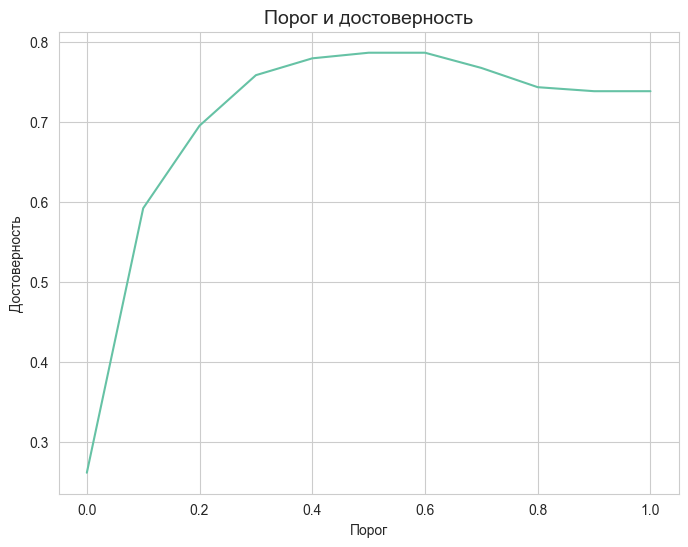

In [106]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(threshold, accuracies)
plt.title('Порог и достоверность', fontsize=14)
plt.xlabel('Порог')
plt.ylabel('Достоверность')
plt.show()

In [90]:
# Создаем базовую линию наиболее частого предсказания
size_val = len(y_val)
baseline = np.repeat(False, size_val)
accuracy_score(baseline, y_val)

0.7381703470031545

### Матрица ошибок

In [91]:
t = 0.5
predict_churn = (y_pred_val>=t)
predict_no_churn = (y_pred_val<t)

true_churn = (y_val == 1)
true_no_churn = (y_val == 0)

TP = (predict_churn & true_churn).sum()
FP = (predict_churn & true_no_churn).sum()

FN = (predict_no_churn & true_churn).sum()
TN = (predict_no_churn & true_no_churn).sum()

confusion_table = np.array(
    [[TN, FP],
     [FN, TP]])
confusion_table

array([[1036,  134],
       [ 205,  210]], dtype=int64)

In [92]:
ct = confusion_table / confusion_table.sum()
ct

array([[0.65362776, 0.08454259],
       [0.12933754, 0.13249211]])

In [93]:
precision = round(TP /(TP+FP), 3)
recall = round(TP /(TP+FN), 3)
print(f'precision: {precision}\nrecall: {recall}')

precision: 0.61
recall: 0.506


### ROC AUC

In [94]:
FPR = FP/(FP + TN)
print(f"Доля ложно положительных результатов: {round(FPR, 3)}")

Доля ложно положительных результатов: 0.115


In [95]:
TPR = TP/(TP + FN)
round(TPR, 3)
print(f"Доля истинно положительных результатов: {round(TPR, 3)}")

Доля истинно положительных результатов: 0.506


In [98]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred_val>= t) & (y_val == 1)).sum()
    fp = ((y_pred_val >= t) & (y_val == 0)).sum()
    fn = ((y_pred_val < t) & (y_val == 1)).sum()
    tn = ((y_pred_val < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))


In [100]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores[::10]

,thresholds,tp,fp,fn,tn
0,0.0,415,1170,0,0
10,0.1,390,622,25,548
20,0.2,367,435,48,735
30,0.3,308,276,107,894
40,0.4,266,201,149,969
50,0.5,210,134,205,1036
60,0.6,145,69,270,1101
70,0.7,71,26,344,1144
80,0.8,8,1,407,1169
90,0.9,0,0,415,1170


In [101]:
df_scores['tpr'] = df_scores['tp']/(df_scores['tp'] + df_scores['fn'])
df_scores['fpr'] = df_scores['fp']/(df_scores['fp'] + df_scores['tn'])
df_scores[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.0,415,1170,0,0,1.000000,1.000000
10,0.1,390,622,25,548,0.939759,0.531624
20,0.2,367,435,48,735,0.884337,0.371795
30,0.3,308,276,107,894,0.742169,0.235897
40,0.4,266,201,149,969,0.640964,0.171795
50,0.5,210,134,205,1036,0.506024,0.114530
60,0.6,145,69,270,1101,0.349398,0.058974
70,0.7,71,26,344,1144,0.171084,0.022222
80,0.8,8,1,407,1169,0.019277,0.000855
90,0.9,0,0,415,1170,0.000000,0.000000


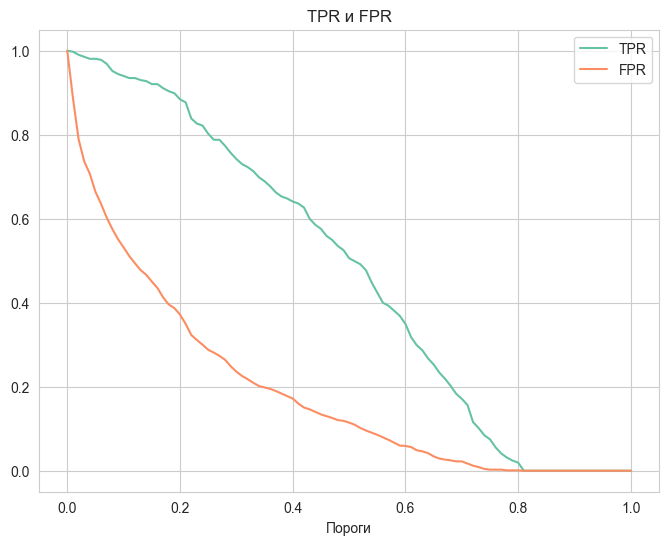

In [105]:
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(df_scores['thresholds'], df_scores['tpr'], label='TPR')
plt.plot(df_scores['thresholds'], df_scores['fpr'], label='FPR')
plt.title('TPR и FPR')
plt.xlabel('Пороги')
plt.legend()
plt.show()

### Сравнение случайной и иделаьной моделей